$\newcommand{\Sum}{\sum\limits}
\newcommand{\Int}{\int\limits}
\newcommand{\Intf}{\int\limits_{-\infty}^{+\infty}}
\newcommand{\Prod}{\prod\limits}
\newcommand{\Max}{\max\limits}
\newcommand{\Min}{\min\limits}
\newcommand{\Lim}{\lim\limits}
\newcommand{\Var}{\mathbb{V}}
\newcommand{\Exp}{\mathbb{E}}
\newcommand{\argmax}{\arg\max}
\newcommand{\Cov}{\mathrm{Cov}}
\newcommand{\makebold}[1]{\boldsymbol{#1}}
\newcommand{\mean}[1]{\overline{#1}}
\newcommand{\Prob}{\mathcal{P}}
\newcommand{\lp}{\left}
\newcommand{\rp}{\right}
\newcommand{\boldX}{\boldsymbol{X}}
\newcommand{\boldY}{\boldsymbol{Y}}
\newcommand{\boldZ}{\boldsymbol{Z}}
\newcommand{\Poisson}{\mathrm{Poisson}}
\newcommand{\Uniform}{\mathrm{Uniform}}
\newcommand{\Binomial}{\mathrm{Binomial}}
\newcommand{\Gammap}{\mathrm{Gamma}}
\newcommand{\Normal}{\mathcal{N}}
\newcommand{\LogN}{\mathrm{LogN}}
\newcommand{\Exponential}{\mathrm{Exp}}
\newcommand{\Erlang}{\mathrm{Erlang}}
\newcommand{\Cauchy}{C}$

## Математическая статистика в машинном обучении

## Д/З №3

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain, combinations

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KernelDensity

## Задача 12: регрессия для качества вин; $Cp, AIC, BIC, LOO$

In [2]:
wines = pd.read_csv('winequality-white.csv', sep=';')
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Обучение baseline модели на всех признаках

In [3]:
X = wines.drop('quality', axis=1)
X['intercept'] = 1. # добавили единичную колонку, но intercept учить не будем
y = wines['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape[0], X_test.shape[0]

(3673, 1225)

In [4]:
model = LinearRegression(fit_intercept=False)
model = model.fit(X_train, y_train)

In [5]:
print(f'R-Square: {model.score(X_train, y_train):.2f}')
print('Features coefs:')

for k, v in zip(X_train.columns, model.coef_):
    print('->', k.ljust(23), f'{v:.4f}')

R-Square: 0.28
Features coefs:
-> fixed acidity           0.0513
-> volatile acidity        -1.8798
-> citric acid             -0.0871
-> residual sugar          0.0739
-> chlorides               0.2526
-> free sulfur dioxide     0.0050
-> total sulfur dioxide    -0.0003
-> density                 -128.9101
-> pH                      0.6513
-> sulphates               0.6857
-> alcohol                 0.2255
-> intercept               128.8093


In [6]:
y_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print(f'MSE (test) = {mse_test:.3f}')

MSE (test) = 0.565


#### Полный перебор всех сочетаний признаков и подсчет критериев

In [7]:
n_features = len(X_train.columns)
print(f'Features: {n_features}, all combinations: {2**n_features}')

Features: 12, all combinations: 4096


Формулы для $C_p, AIC, BIC, LOO$ и критерии выбора признаков (max/min):
* из [James G., Witten D. etc. "An Introduction to Statistical Learning with Applications in R, p. 211-212](https://www.ime.unicamp.br/~dias/Intoduction%20to%20Statistical%20Learning.pdf):
$$C_p = \frac{1}{n}(RSS + 2d\hat{\sigma}^2) \rightarrow \min$$
$$AIC = \frac{1}{n\hat{\sigma}^2}(RSS + 2d\hat{\sigma}^2) \rightarrow \max$$
$$BIC = \frac{1}{n}(RSS + \log(n)d\hat{\sigma}^2) \rightarrow \min$$
* с семинара
$$
\hat{R}_{LOO}(a;X,y) = \sum_{i = 1}^n \big( \frac{y_i - a(x_i;X,y)}{1 - \|X(X^TX)^{-1}\boldX^T\|_{ii}}\big)^2 \rightarrow \min
$$

In [8]:
def CP_Mallow(X, y, weights):
    """From seminar_05_regression.ipynb"""
    n_samples, n_features = X.shape
    squares = (y - np.dot(X, weights))**2
    sigma = np.sum(squares) / (n_samples - n_features)
    cp_mallow = (np.sum(squares) + 2 * n_features * sigma) / n_samples
    return cp_mallow

def AIC(X, y, weights):
    n_samples, n_features = X.shape
    squares = (y - np.dot(X, weights))**2
    sigma = np.sum(squares) / (n_samples - n_features)
    aic = (np.sum(squares) + 2 * n_features * sigma) / (n_samples * sigma)
    return aic
           
def BIC(X, y, weights):
    n_samples, n_features = X.shape
    squares = (y - np.dot(X, weights))**2
    sigma = np.sum(squares) / (n_samples - n_features)
    aic = (np.sum(squares) + np.log(n_samples) * n_features * sigma) / n_samples
    return aic

def LOO(X, y, weights):
    """From seminar_05_regression.ipynb"""
    n_samples, n_features = X.shape
    U = np.dot(np.dot(X, np.linalg.inv(np.dot(X.T, X))), X.T)
    U = U[np.arange(n_samples), np.arange(n_samples)]
    return np.sum(((y - np.dot(X, weights)) / (1 - U)) ** 2) / n_samples

In [12]:
linreg = LinearRegression(fit_intercept=False)
data = {
    'features_subset': [], 
    'n_features': [], 
    'MSE': [], 
    'CP_Mallow': [], 
    'AIC': [], 
    'BIC': [], 
    'LOO': [], 
}
columns = X_train.columns[:-1] # кроме intercept

for features_subset in tqdm(chain.from_iterable(combinations(columns, n) 
                                                for n in range(1, n_features)),
                            total=2**(n_features - 1)):
    features_subset = list(features_subset) + ['intercept']
    X_train_ = X_train[features_subset].values
    X_test_ = X_test[features_subset].values
    
    linreg = linreg.fit(X_train_, y_train)
    weights = linreg.coef_
    y_pred_ = linreg.predict(X_test_)
    
    data['features_subset'].append(list(features_subset))
    data['n_features'].append(len(features_subset))
    data['MSE'].append(mean_squared_error(y_test, y_pred_))
    data['CP_Mallow'].append(CP_Mallow(X_test_, y_test, weights))
    data['AIC'].append(AIC(X_test_, y_test, weights))
    data['BIC'].append(BIC(X_test_, y_test, weights))
    data['LOO'].append(LOO(X_test_, y_test, weights))
    
results = pd.DataFrame(data)

100%|█████████▉| 2047/2048 [00:10<00:00, 199.93it/s]


In [14]:
for criterion in ['CP_Mallow', 'AIC', 'BIC', 'LOO']:
    if criterion == 'AIC':
        best = results.sort_values(by=criterion).tail(1)
    else:
        best = results.sort_values(by=criterion).head(1)

    feats = best['features_subset'].iloc[0]
    n_feats = best['n_features'].iloc[0] - 1
    metric = best[criterion].iloc[0]
    mse = best['MSE'].iloc[0]
    
    print(f'Best of {criterion}')
    print('-'*20)
    print(f'-> d = {n_feats}')
    print(f'''-> {' | '.join(feats)}''')
    print(f'-> criterion = {metric:.4f}')
    
    if mse < mse_test:
        print(f'✔ BETTER than baseline in terms of MSE: {mse:.4f} < {mse_test:.4f}')
    else:
        print(f'× NOT better than baseline in terms of MSE: {mse:.4f} > {mse_test:.4f}')
    
    print('-'*20)

Best of CP_Mallow
--------------------
-> d = 6
-> fixed acidity | volatile acidity | residual sugar | density | pH | sulphates | intercept
-> criterion = 0.5624
✔ BETTER than baseline in terms of MSE: 0.5560 < 0.5646
--------------------
Best of AIC
--------------------
-> d = 11
-> fixed acidity | volatile acidity | citric acid | residual sugar | chlorides | free sulfur dioxide | total sulfur dioxide | density | pH | sulphates | alcohol | intercept
-> criterion = 1.0098
× NOT better than baseline in terms of MSE: 0.5646 > 0.5646
--------------------
Best of BIC
--------------------
-> d = 6
-> fixed acidity | volatile acidity | residual sugar | density | pH | sulphates | intercept
-> criterion = 0.5787
✔ BETTER than baseline in terms of MSE: 0.5560 < 0.5646
--------------------
Best of LOO
--------------------
-> d = 6
-> fixed acidity | volatile acidity | residual sugar | density | pH | sulphates | intercept
-> criterion = 0.5629
✔ BETTER than baseline in terms of MSE: 0.5560 < 0.56

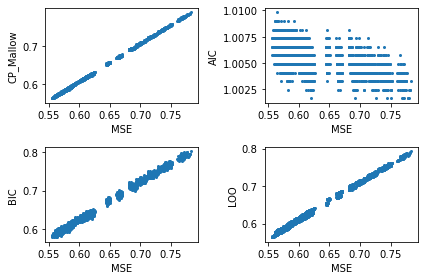

In [15]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(results['MSE'], results['CP_Mallow'], s=4)
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('CP_Mallow')

axs[0, 1].scatter(results['MSE'], results['AIC'], s=4)
axs[0, 1].set_xlabel('MSE')
axs[0, 1].set_ylabel('AIC')

axs[1, 0].scatter(results['MSE'], results['BIC'], s=4)
axs[1, 0].set_xlabel('MSE')
axs[1, 0].set_ylabel('BIC')

axs[1, 1].scatter(results['MSE'], results['LOO'], s=4)
axs[1, 1].set_xlabel('MSE')
axs[1, 1].set_ylabel('LOO')

plt.tight_layout()
plt.show()

__Выводы:__

* критерии Cp/BIC/LOO сократили набор признаков с 11 до 6 и улучшили качество с MSE = 0.5646 до 0.5560, по сравнению с базовой моделью, где использовались все признаки
* критерий AIC оставил все признаки и качество не улучшил

## Задача 13: коэф-т преломления стекла, гистограммная и ядерная оценка плотности

In [18]:
glass = pd.read_csv('glass.txt', delim_whitespace=True)
samples = glass['RI']

### Гистограммная оценка

In [19]:
def create_binedges(center, bandwidth, x_left, x_right):
    """
    Функция для удобного создания бинов заданной ширины и с заданным положением центра одного из бинов
    :param center: Значение центра одного из бинов
    :param bandwidth: Ширина бина
    :param x_left: Значение левой границы самого левого бина не больше x_left
    :param x_right: Значение правой границы самого правого бина не меньше x_right
    """
    bins = [center - bandwidth / 2]
    while x_left < bins[-1]:
        bins.append(bins[-1] - bandwidth)
    bins = list(reversed(bins))
    while x_right > bins[-1]:
        bins.append(bins[-1] + bandwidth)
    return bins

def histogram_pdf_estimated_risk(bincounts, bandwidth=None, n_bins=None):
    """Cross-validation score of estimated risk for histogram"""
    h = bandwidth
    n = np.sum(bincounts)
    ps = bincounts / n
    return 2 / ((n - 1) * h) - ((n + 1.0) / (h * (n - 1.0))) * np.sum(ps ** 2)

#### PDF для некоторой ширины бина

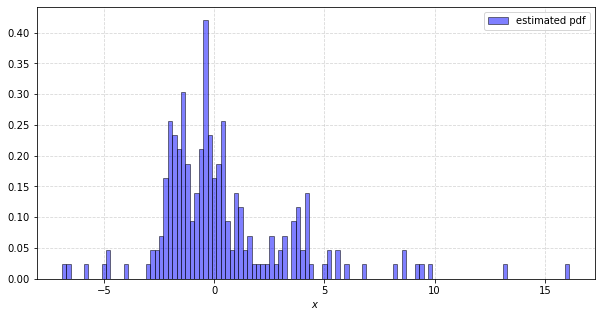

In [20]:
bandwidth = 0.2
binedges = create_binedges(0., bandwidth, samples.min(), samples.max())

plt.figure(figsize=(10, 5))
plt.hist(samples, bins=binedges, color='b', density=True, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2)
plt.xlabel(r'$x$')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

#### Функция $\hat{J}(h)$ оценки риска

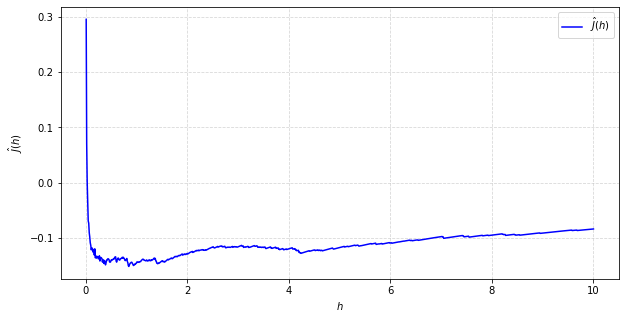

In [21]:
bandwidth_range = np.linspace(0.01, 10, 1000)
risk_values = []
for bandwidth in bandwidth_range:
    binedges = create_binedges(0., bandwidth, samples.min(), samples.max())
    bincounts, _ = np.histogram(samples, bins=binedges)
    risk_values.append(histogram_pdf_estimated_risk(bincounts, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 5))
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.xlabel(r'$h$'); plt.ylabel(r'$\hat{J}(h)$')
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

In [22]:
# Finding the optimal bandwidth
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

h = 0.85, J = -0.15101950995817837


#### PDF для оптимальной ширины бина

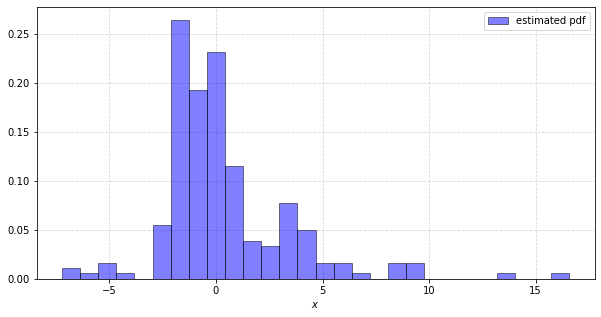

In [30]:
binedges = create_binedges(0, opt_bandwidth, samples.min(), samples.max())
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=binedges, color='b', density=True, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2)
plt.xlabel(r'$x$')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

#### Доверительный интервал

In [24]:
def make_density(bincounts, binedges):
    return bincounts / (bincounts.sum() * np.diff(binedges))

def histogram_pdf_confidence_interval(bincounts, n_bins, n_samples, binedges, density=True, alpha=0.05):
    m = n_bins
    hat_f_n = bincounts
    n = n_samples
    z = abs(stats.norm().ppf(alpha / (2*m)))
    c = (z / 2) * np.sqrt(m / n)
    lower_bounds = np.clip(np.sqrt(hat_f_n) - c, 0, np.inf) ** 2
    upper_bounds = (np.sqrt(hat_f_n) + c) ** 2

    if density:
        lower_bounds, upper_bounds = make_density(lower_bounds, binedges), make_density(upper_bounds, binedges)
    
    return lower_bounds, upper_bounds

In [31]:
n_bins = len(binedges) - 1
n_samples = len(samples)
bincounts, _ = np.histogram(samples, bins=binedges)

lower_bounds, upper_bounds = histogram_pdf_confidence_interval(bincounts, n_bins, n_samples, binedges, density=False)

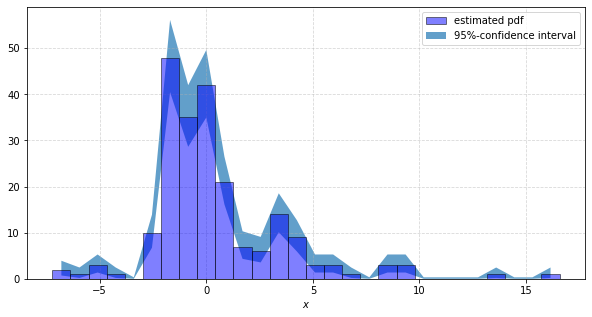

In [32]:
binedges = create_binedges(0, opt_bandwidth, samples.min(), samples.max())
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=binedges, color='b', density=False, edgecolor='k', 
         label='estimated pdf', alpha=0.5, zorder=2)

bins_centers = np.array(binedges[:-1]) + opt_bandwidth / 2
plt.fill_between(bins_centers, lower_bounds, upper_bounds, alpha=0.7, label='95%-confidence interval')

plt.xlabel(r'$x$')
plt.legend()
plt.grid(which='both', linestyle='--', alpha=0.5)

### Ядерная оценка

In [33]:
def gaussian_kernel_estimated_risk(samples, bandwidth):
    """Calculates the risk for gaussian kernel

    :param samples: 1D numpy array with samples
    :param bandwidth: bandwidth parameter of gaussian kernel

    :rtype: float
    :returns: Estimated risk value
    """
    X = samples
    h = bandwidth
    n = len(X)
    Jh = 0
    Xi = X[None, :]
    Xj = X[:, None]
    points = (Xi - Xj) / h
    Jh = np.sum(stats.norm.pdf(points, loc=0, scale=np.sqrt(2))) -\
        2 * np.sum(stats.norm.pdf(points, loc=0, scale=1))
    Jh /= h * (n**2)
    Jh += (2.0 / (h * n)) * stats.norm.pdf(0, loc=0, scale=1)
    return Jh

#### PDF для некоторой ширины ядра

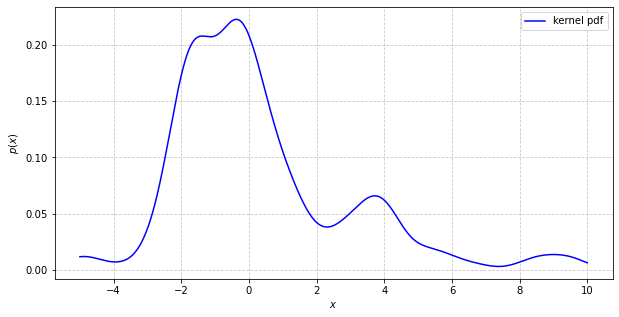

In [34]:
x_values = np.linspace(-5, 10, 1000)
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(samples[:, None])
log_probas = kde.score_samples(x_values[:, None])

plt.figure(figsize=(10, 5))
plt.plot(x_values, np.exp(log_probas), color='b', label='kernel pdf')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.grid(which='both', alpha=0.7, linestyle='--')
plt.legend()

#### Функция $\hat{J}(h)$ оценки риска

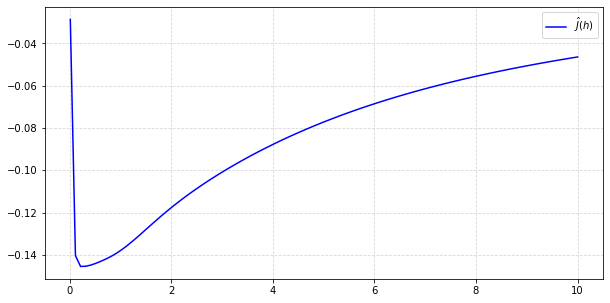

In [35]:
bandwidth_range = np.linspace(0.01, 10, 100)
risk_values = []
for bandwidth in bandwidth_range:
    risk_values.append(gaussian_kernel_estimated_risk(samples, bandwidth))
risk_values = np.array(risk_values)

plt.figure(figsize=(10, 5))
plt.plot(bandwidth_range, risk_values, color='b', label=r'$\hat{J}(h)$', zorder=2);
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

In [36]:
index_min = np.argmin(risk_values)
opt_bandwidth = bandwidth_range[index_min]
min_risk = risk_values[index_min]
print('h = {}, J = {}'.format(opt_bandwidth, min_risk))

h = 0.21181818181818182, J = -0.14547023406344872


#### PDF для оптимальной ширины ядра

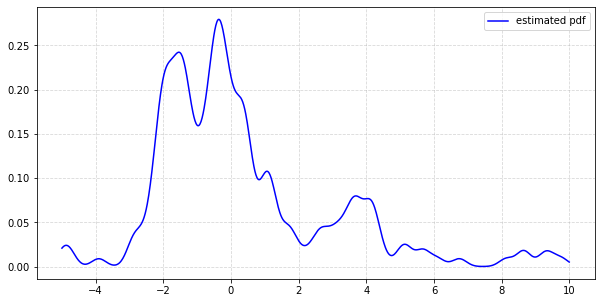

In [37]:
kde = KernelDensity(kernel='gaussian', bandwidth=opt_bandwidth)
kde.fit(samples[:,None])
pdf = np.exp(kde.score_samples(x_values[:,None]))

plt.figure(figsize=(10, 5))
plt.plot(x_values, pdf, color='b', label='estimated pdf', zorder=2)
plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

#### Доверительный интервал

In [38]:
def gaussian_kernel_confidence_interval(x_values, pdf, opt_bandwidth, alpha=0.05):
    n = len(pdf)
    m = (x_values.max() - x_values.min()) / opt_bandwidth
    s2_x = np.sum((pdf - np.mean(pdf))**2) / (n - 1)
    se_x = np.sqrt(s2_x / n)
    q = abs(stats.norm().ppf((1 + (1 - 0.05) ** (1 / m)) / 2))
    lower_bound, upper_bound = pdf - q * se_x, pdf + q * se_x
    return lower_bound, upper_bound

In [39]:
lower_bound, upper_bound = gaussian_kernel_confidence_interval(x_values, pdf, opt_bandwidth)

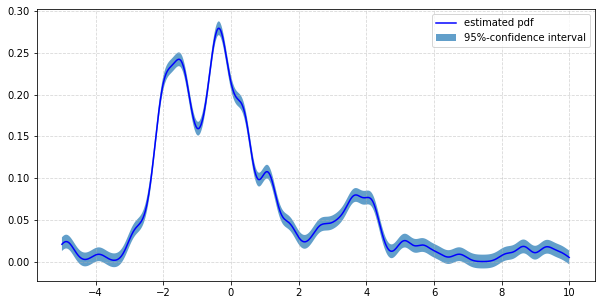

In [40]:
kde = KernelDensity(kernel='gaussian', bandwidth=opt_bandwidth)
kde.fit(samples[:,None])
pdf = np.exp(kde.score_samples(x_values[:,None]))

plt.figure(figsize=(10, 5))
plt.plot(x_values, pdf, color='b', label='estimated pdf', zorder=2)
plt.fill_between(x_values, lower_bound, upper_bound, alpha=0.7, label='95%-confidence interval')

plt.legend();
plt.grid(which='both', linestyle='--', alpha=0.5);

__Вывод:__
* С помощью ядерной оценки получили более точную оценку плотности - доверительный интервал заметно уже, чем в случае гистограммной оценки

## Задача 14: коэф-т преломления стекла, ядерная непараметрическая регрессия

In [54]:
Y = glass['RI'].values
X = glass['Al'].values

In [55]:
class GaussianKernel:
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.scale = scale

    def __call__(self, x):
        return stats.norm.pdf(x, loc=self.loc, scale=self.scale)


class NadarayaWatsonRegressor:
    def __init__(self, kernel, bandwidth):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def fit(self, X, Y):
        self.X = np.array(X)
        self.Y = np.array(Y)

    def predict(self, X):
        K_X = (X[:, None] - self.X[None, :]) / self.bandwidth
        K = self.kernel(K_X)
        predictions = np.sum(K * Y[None, :], axis=1) / np.sum(K, axis=1)
        return predictions


def nw_regression_estimated_risk(X, Y, bandwidth, kernel=None):
    if kernel is None:
        kernel = GaussianKernel()
    h = bandwidth
    nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), h)
    nw_regressor.fit(X, Y)
    Y_pred = nw_regressor.predict(X)
    K_X = (X.reshape((-1, 1)) - X.reshape((1, -1))) / h
    K = kernel(K_X)
    K_sums = np.sum(K, axis=1)
    J = np.sum((((Y - Y_pred) * K_sums) / (K_sums - kernel(0)))**2)
    return J

### Регрессия Надарая-Ватсона

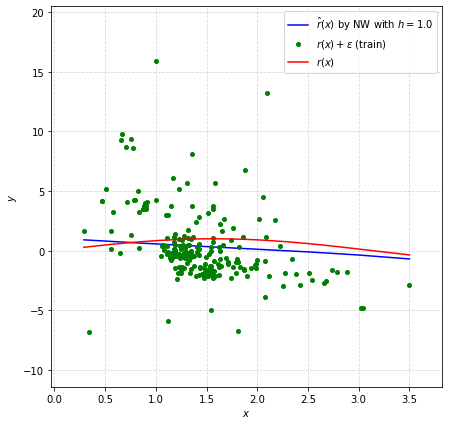

In [56]:
bandwidth = 1.
nw_regressor = NadarayaWatsonRegressor(GaussianKernel(), bandwidth)
indices = np.argsort(X)
X = X[indices]
Y = Y[indices]
nw_regressor.fit(X, Y)
Y_pred = nw_regressor.predict(X)

x_values = np.linspace(X.min(), X.max(), 1001)

plt.figure(figsize=(7, 7))
plt.plot(X, Y_pred, color='b', label='$\hat{{r}}(x)$ by NW with $h = {}$'.format(bandwidth), zorder=2)
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)',
         zorder=2)
plt.plot(x_values, np.sin(x_values), color='r', label='$r(x)$')
plt.legend()
plt.xlabel('$x$');
plt.ylabel('$y$');
x_span = X.max() - X.min()
y_span = Y.max() - Y.min() 
plt.xlim([X.min() - 0.1 * x_span, X.max() + 0.1 * x_span])
plt.ylim([Y.min() - 0.2 * y_span, Y.max() + 0.2 * y_span])
plt.grid(which='both', linestyle='--', alpha=0.5);

### Выбор оптимальной ширины ядра

h=0.13, J(h)=1466.9099608384945


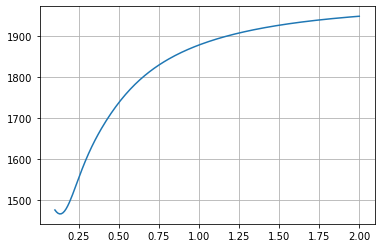

In [57]:
bandwidth_values = np.linspace(0.1, 2, 191)

estimated_risks = []
for bandwidth in bandwidth_values:
    risk = nw_regression_estimated_risk(X, Y, bandwidth, kernel=GaussianKernel())
    estimated_risks.append(risk)

bandwidth_opt = bandwidth_values[np.argmin(estimated_risks)]
print(f'h={bandwidth_opt}, J(h)={estimated_risks[np.argmin(estimated_risks)]}')

plt.plot(bandwidth_values, estimated_risks)
plt.grid();

### Построение доверительной трубки

In [59]:
alpha = 0.95
h = bandwidth_opt
n = len(X)

m = (b - a) / (3 * h)
q = scipy.stats.norm.ppf((1 + (1 - alpha)**(1 / m)) / 2.)
sigma = np.sqrt(np.sum((Y[1:] - Y[:-1])**2) / (2 * (n - 1)))

kernel = GaussianKernel()
K = kernel((x_values[:, None] - X[None, :]) / h)
W = K / K.sum(axis=1)[:, None]
se = sigma * np.sqrt(np.sum(W ** 2, axis=1))

Y_pred = np.sum(W * Y[None, :], axis=1)
lower = Y_pred - q * se
upper = Y_pred + q * se

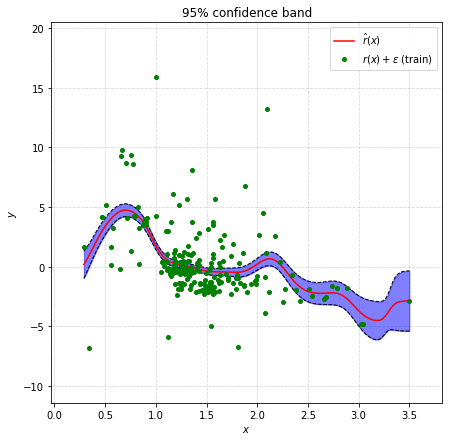

In [60]:
plt.figure(figsize=(7, 7))
plt.fill_between(x_values, lower, upper, color='b', alpha=0.5, zorder=2)
plt.plot(x_values, lower, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, upper, color='k', linewidth=1, linestyle='--')
plt.plot(x_values, Y_pred, color='r', label=r'$\hat{r}(x)$')
plt.plot(X, Y, color='g', marker='o', markersize=4, linestyle='none', label=r'$r(x) + \varepsilon$ (train)')

# Limits
x_span = X.max() - X.min()
y_span = Y.max() - Y.min() 
plt.xlim([X.min() - 0.1 * x_span, X.max() + 0.1 * x_span])
plt.ylim([Y.min() - 0.2 * y_span, Y.max() + 0.2 * y_span])

# Labels
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('95% confidence band')

plt.legend()
plt.grid(which='both', alpha=0.5, linestyle='--');

__Выводы:__

* Восстановили зависимость с помощью регрессии Надарая-Ватсона и оценили доверительный интервал: где точек больше, он заметно уже, где меньше - шире